In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import datetime
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pathlib import Path

pl.enable_string_cache()

### functions to draw cue box and assign sex

In [137]:

from coral.config_loader import ConfigLoader
from coral.experimental_metadata import ExperimentMetaData
from coral.data_preprocessor import BehaviorDataPreprocessor, PhotometryDataPreprocessor
config_path = '/Volumes/fsmresfiles/Basic_Sciences/Phys/Lerner_Lab_tnl2633/Mike/LHA_dopamine/LH_NAC_Headfix_FP/Photometry/Pav_Training/claire_cohort/conf/config.yaml'
configs = ConfigLoader(config_path)
sucralose_start_date_str = configs.config_data['reward_dates']['sucralose']

sucralose_start_date = datetime.datetime.strptime(
    sucralose_start_date_str, '%m-%d-%Y').date()

males = configs.config_data['males']

In [84]:
def draw_cue_box(ax, color, alpha):
    #  draw box on plot for cue
    y_lower = ax.get_ylim()[0]
    y_ags_sum = sum(np.abs(ax.get_ylim()))
    rect = patches.Rectangle(
        (0, y_lower), width=5, height=y_ags_sum, alpha=alpha, facecolor=color)
    ax.add_patch(rect)
    return rect


def assign_sex(df, males):
    df = df.with_columns(pl.col('subject').is_in(males).alias('male'))
    return df

males = [3634, 3814, 3816, 3812, 38131]

def assign_reward(df:pl.DataFrame, sucralose_start_date:datetime.date):    
    new_df = (
        df
        .with_columns(
            pl.when(pl.col('date') >= sucralose_start_date).then(
                True).otherwise(False).alias('sucralose'),
        )
    )
    return new_df

def add_sex_and_sucralose_column(df, males, sucralose_start_date):
     sex_df= assign_sex(df, males)
     return assign_reward(sex_df, sucralose_start_date)

### paths to data

In [131]:
behavior_path = Path(
    '/Volumes/fsmresfiles/Basic_Sciences/Phys/Lerner_Lab_tnl2633/Mike/LHA_dopamine/LH_NAC_Headfix_FP/Photometry/Pav_Training/claire_cohort/analyzed_data/aggregated_data/aggregated_behavior_data.parquet')
fp_path = Path('/Volumes/fsmresfiles/Basic_Sciences/Phys/Lerner_Lab_tnl2633/Mike/LHA_dopamine/LH_NAC_Headfix_FP/Photometry/Pav_Training/claire_cohort/analyzed_data/aggregated_data/aggregated_photometry_data.parquet')
filter_date = datetime.date(2024, 2, 9)

### read behavior data and baseline correct from -3 to 0

In [86]:
bh_df = pl.read_parquet(behavior_path).drop("__index_level_0__").sort('date').sort('subject')


baselines = (bh_df
             .filter(
                 (pl.col('time') <0) 
                 & 
                 (pl.col('time') > -3))
             .group_by(['subject', 'date']).mean()
             .drop(['time', 'time_recorded', 'user'])
             )
baseline_corrected_df = (bh_df
                        #  .filter(pl.col('date') > filter_date)
             .join(baselines, on = ['subject', 'date'], how = 'left', suffix = '_baseline')
             .with_columns(
                 (pl.col('encoder_aligned_to_cue') - pl.col('encoder_aligned_to_cue_baseline')).alias('encoder_aligned_to_cue_baseline_corrected'),
                 (pl.col('lick_aligned_to_cue') - pl.col('lick_aligned_to_cue_baseline')).alias('lick_aligned_to_cue_baseline_corrected'),
                 (pl.col('lick_aligned_to_reward') - pl.col('lick_aligned_to_reward_baseline')).alias('lick_aligned_to_reward_baseline_corrected'),
                 (pl.col('encoder_aligned_to_reward') - pl.col('encoder_aligned_to_reward_baseline')).alias('encoder_aligned_to_reward_baseline_corrected'),
                 (pl.col('subject').cast(pl.Int32))
             )
             .drop(['lick_aligned_to_cue', 'encoder_aligned_to_cue', 'lick_aligned_to_reward', 'encoder_aligned_to_reward', 'lick_aligned_to_reward_baseline', 'encoder_aligned_to_reward_baseline', 'encoder_aligned_to_cue_baseline', 'lick_aligned_to_cue_baseline'])
)
baseline_corrected_df = add_sex_and_sucralose_column(baseline_corrected_df, males, sucralose_start_date)
baseline_corrected_df

subject,user,date,time_recorded,time,encoder_aligned_to_cue_baseline_corrected,lick_aligned_to_cue_baseline_corrected,lick_aligned_to_reward_baseline_corrected,encoder_aligned_to_reward_baseline_corrected,male,sucralose
i32,cat,datetime[ns],datetime[ns],f64,f64,f64,f64,f64,bool,bool
117,"""User""",2024-02-01 00:00:00,2024-02-23 14:53:30,-10.0,-2.510081,-0.110887,0.252016,0.735887,false,false
117,"""User""",2024-02-01 00:00:00,2024-02-23 14:53:30,-9.805195,-2.1875,-0.272177,0.252016,0.252016,false,false
117,"""User""",2024-02-01 00:00:00,2024-02-23 14:53:30,-9.61039,-2.1875,-0.272177,0.252016,0.574597,false,false
117,"""User""",2024-02-01 00:00:00,2024-02-23 14:53:30,-9.415584,-2.1875,-0.110887,0.252016,0.252016,false,false
117,"""User""",2024-02-01 00:00:00,2024-02-23 14:53:30,-9.220779,-2.1875,0.050403,0.252016,-0.877016,false,false
117,"""User""",2024-02-01 00:00:00,2024-02-23 14:53:30,-9.025974,-1.864919,-0.433468,0.252016,0.090726,false,false
117,"""User""",2024-02-01 00:00:00,2024-02-23 14:53:30,-8.831169,-1.542339,-0.433468,0.090726,-0.070565,false,false
117,"""User""",2024-02-01 00:00:00,2024-02-23 14:53:30,-8.636364,-2.1875,-0.433468,0.252016,-0.393145,false,false
117,"""User""",2024-02-01 00:00:00,2024-02-23 14:53:30,-8.441558,-1.864919,-0.433468,0.252016,-0.877016,false,false


# Licks aligned to cue

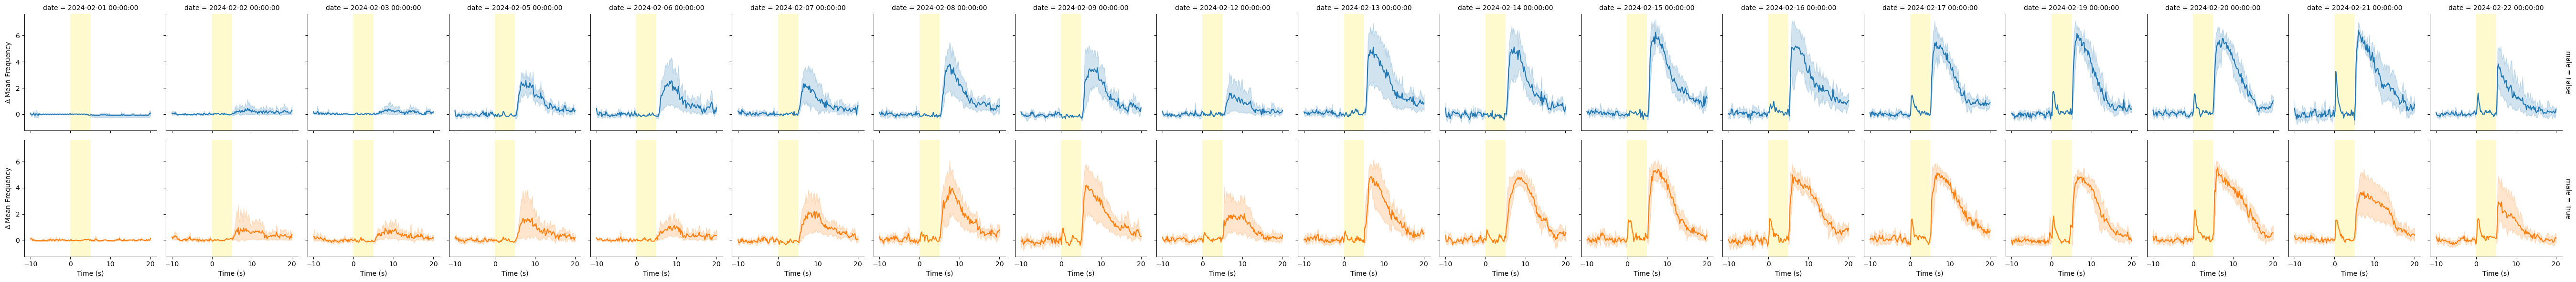

In [22]:
facet = sns.FacetGrid(baseline_corrected_df, col='date', row = 'male', hue = 'male',
                      height=3, aspect=1, margin_titles=True)
facet.map(sns.lineplot, 'time',
          'lick_aligned_to_cue_baseline_corrected')
# facet.map(sns.lineplot, 'time','encoder_aligned_to_cue_baseline_corrected', color = 'grey')
for ax in facet.axes.flat:
    draw_cue_box(ax, color='lemonchiffon', alpha=1)
    ax.set_ylabel(r'$\Delta$ Mean Frequency')
    ax.set_xlabel('Time (s)')
# facet.figure.text(-0.5, 2, 'Lick', color = 'lightblue', size = 20)
    

### mean anticipatory licks

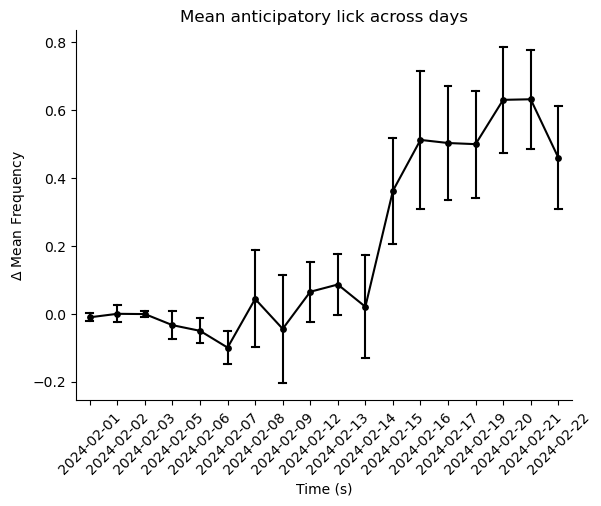

In [23]:
grouped_baseline_al =(
    baseline_corrected_df
             .filter(
                 (pl.col('time') >0) 
                 & 
                 (pl.col('time') <3))
             .group_by(['subject', 'date'])
             .agg([
                 pl.col('lick_aligned_to_cue_baseline_corrected').mean().alias(
                     'mean_cue_lick'),
                 pl.col('lick_aligned_to_cue_baseline_corrected').max().alias(
                     'max_cue_lick')
             ])
             .sort('date')
             .with_columns(
                 (pl.col('subject').cast(pl.Int64))
             )
             
)
def plot_anticipatory_licks(col, title):
    
    sns.pointplot(data = grouped_baseline_al,
                x = 'date',
                y=col,
                #  hue = 'male',
                errorbar='se', 
                linewidth=1.5, 
                color = 'black',
                capsize=0.25,
                err_kws = {"color":'black', 
                            "linewidth": 1.5},
                
                )

    plt.xticks(rotation=45)
    plt.ylabel(r'$\Delta$ Mean Frequency')
    plt.xlabel('Time (s)')
    plt.title(title)
    sns.despine()
    plt.show()
plot_anticipatory_licks('mean_cue_lick', 'Mean anticipatory lick across days')

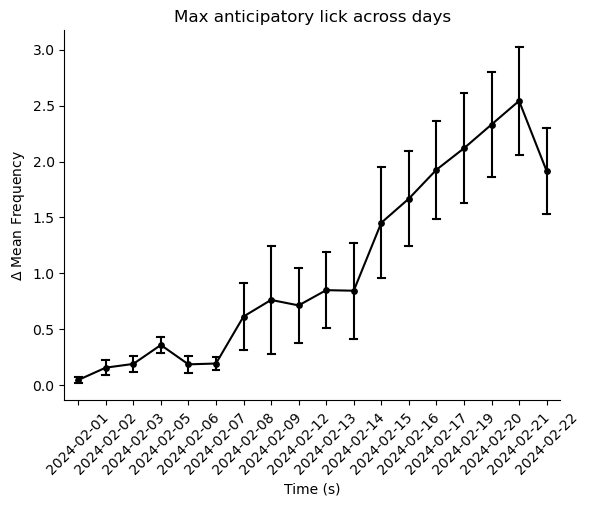

In [24]:
plot_anticipatory_licks('max_cue_lick', 'Max anticipatory lick across days')

#### read fp data and calculate group average

In [89]:
fp_df = pl.read_parquet(fp_path).drop(
    "__index_level_0__").sort('date').sort('subject')
fp_df = assign_sex(fp_df, males)
fp_df = pl.read_parquet(fp_path).drop(
    "__index_level_0__").sort('date').sort('subject')
fp_df = add_sex_and_sucralose_column(fp_df, males, sucralose_start_date)
grouped_fp = (fp_df
              .drop('time', 'trial', 'user')
              .group_by(*[c for c in fp_df.columns if c not in ['z_score', 'time', 'trial', 'user']])
              .mean()
              )

        
# fp_df['subject'].replace('3813', '3813_1')
# sns.scatterplot(data = auc.query("structures == 'LHA'"), x = 'date', y = 'auc', hue = 'behavioral_events', palette = 'Set2')
grouped_fp

timestamps,behavioral_events,structures,subject,date,male,sucralose,z_score
f32,cat,cat,i64,datetime[μs],bool,bool,f32
-7.985221,"""reward""","""LHA""",117,2024-02-01 00:00:00,false,false,-0.232799
-6.215716,"""reward""","""LHA""",117,2024-02-01 00:00:00,false,false,-0.227642
-4.544516,"""reward""","""LHA""",117,2024-02-01 00:00:00,false,false,-0.235763
0.272471,"""reward""","""LHA""",117,2024-02-01 00:00:00,false,false,0.014707
4.008094,"""reward""","""LHA""",117,2024-02-01 00:00:00,false,false,-0.061083
4.794541,"""reward""","""LHA""",117,2024-02-01 00:00:00,false,false,0.017451
6.564046,"""reward""","""LHA""",117,2024-02-01 00:00:00,false,false,-0.005763
7.350493,"""reward""","""LHA""",117,2024-02-01 00:00:00,false,false,0.090148
9.611528,"""reward""","""LHA""",117,2024-02-01 00:00:00,false,false,0.074827


# Cue Response

In [90]:
exlude = [5079, 117, 3820]
def plot_fp_response(event):
    filtered_data = grouped_fp.filter((pl.col('behavioral_events') == event),
                                        #    (pl.col('date')> "2024-02-06"),
                            # (pl.col('date').map_elements(lambda date: date.day %
                            #  2 == 0, return_dtype=pl.Boolean))
                        # &
                        # # (~pl.col('subject').is_in(exlude))
                        )


    facet = sns.FacetGrid(filtered_data, col='date', row='male', hue='structures', palette=[
                        'red', 'black'], height=3, aspect=1, margin_titles=True)
    facet.map(sns.lineplot, 'timestamps', 'z_score', errorbar='se')
    for ax in facet.axes.flat:
        ax.axvline(5, color='black', linestyle='--')
        draw_cue_box(ax, color='yellow', alpha=0.3)
    plt.legend(loc='upper left')
    plt.tight_layout()

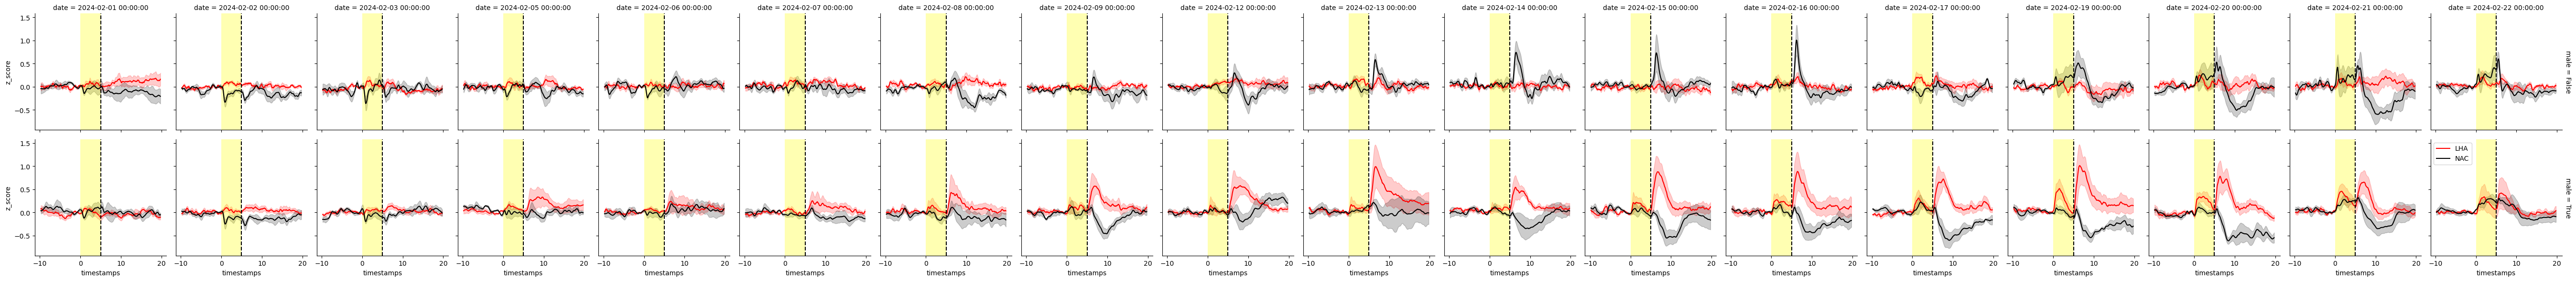

In [27]:
plot_fp_response('cue')

# Reward Response

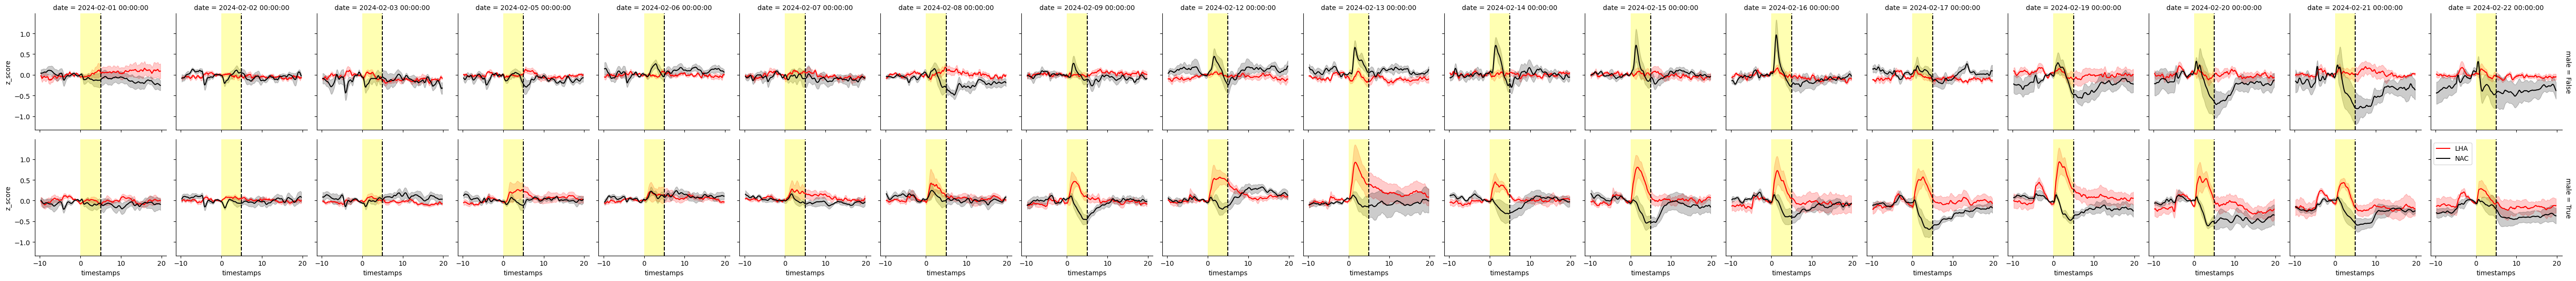

In [28]:
plot_fp_response('reward')

# Individual Cue Response

LHA cue response over days with anticipatory licks

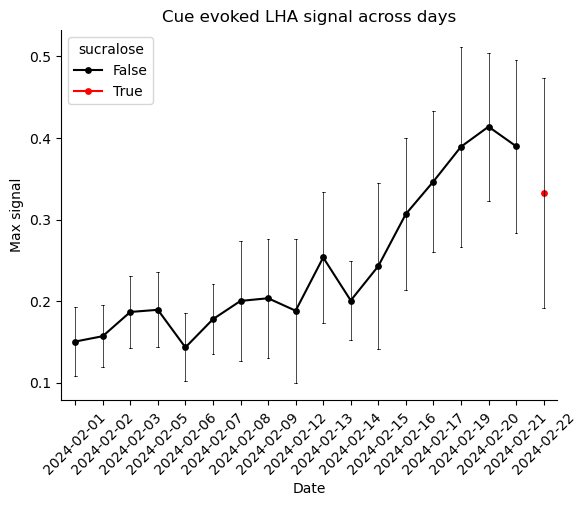

In [116]:

fp_anticipatory = (
    grouped_fp
    .rename({'z_score': 'signal'})
    .filter(
        (pl.col('timestamps') > 0)
        &
        (pl.col('timestamps') < 5))
    .group_by(['subject', 'date', 'structures', 'behavioral_events', 'male', 'sucralose'])
    .agg([
        pl.col('signal').max().alias('max_signal'),
        pl.col('signal').mean().alias('mean_signal'),
        pl.col('signal').min().alias('min_signal'),
        pl.col('signal').sum().alias('sum_signal'),
    ])
    .sort('date')
)

sns.pointplot(data=fp_anticipatory.to_pandas().query(
    "structures =='LHA' & behavioral_events == 'cue'"),
              x='date', 
              y='max_signal',
              errorbar='se', 
              linewidth=1.5, 
              palette=['black', 'red'],
              hue = 'sucralose',
            #   color = 'black',
              capsize=0.1,
              err_kws = {"color":'black', 
                        "linewidth": .5},
             )
plt.xticks(rotation=45)
plt.ylabel(r'Max signal')
plt.xlabel('Date')
plt.title('Cue evoked LHA signal across days')
sns.despine()
plt.show()

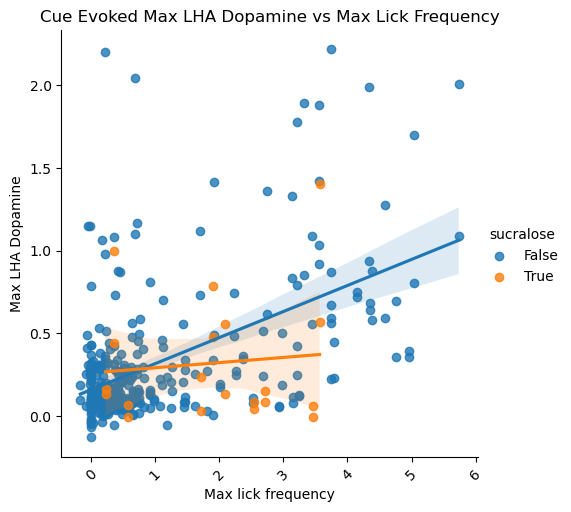

In [108]:

fp_anticipatory = fp_anticipatory.with_columns(
    (pl.col('date').cast(pl.Datetime)))

grouped_baseline_al = grouped_baseline_al.with_columns( (pl.col('date').cast(pl.Datetime)))


combined_anticipatory_data = (fp_anticipatory
                 .join(grouped_baseline_al, on = ['subject', 'date']).sort('date'))



sns.lmplot(data=combined_anticipatory_data.filter(pl.col('structures') == 'LHA'),
           x='max_cue_lick',
            y = 'max_signal', 
            hue = 'sucralose'
            )
plt.xticks(rotation=45)
plt.ylabel('Max LHA Dopamine')
plt.xlabel('Max lick frequency')
plt.title('Cue Evoked Max LHA Dopamine vs Max Lick Frequency')
sns.despine()
plt.show()

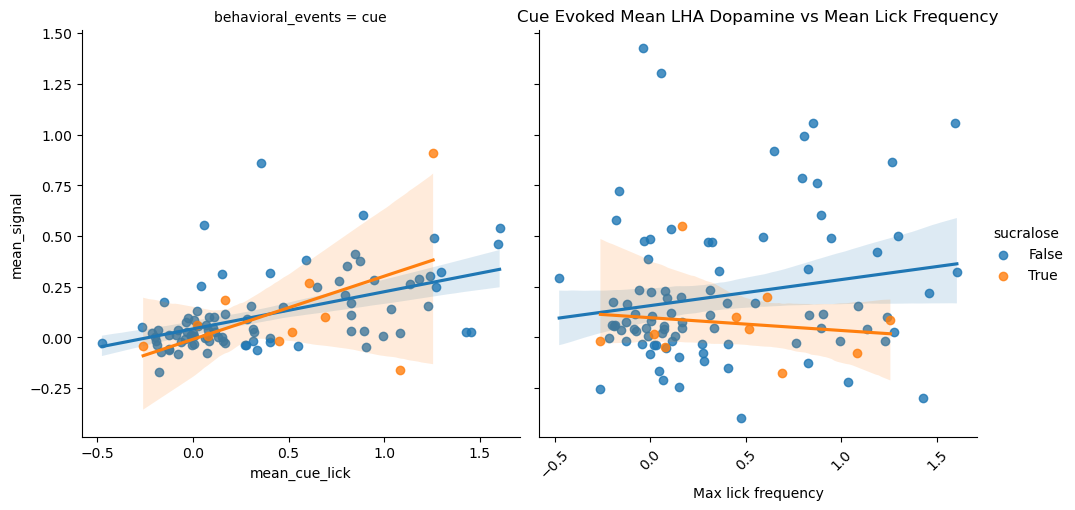

In [134]:
sns.lmplot(data=filtered_data.filter(
    (pl.col('structures') == 'LHA')
    &
    (pl.col('date')>filter_date)
    ),
           x='mean_cue_lick',
           hue = 'sucralose',
           y='mean_signal', 
           col = 'behavioral_events',
           col_order=['cue', 'reward'])
plt.xticks(rotation=45)
plt.ylabel('Max LHA Dopamine')
plt.xlabel('Max lick frequency')
plt.title('Cue Evoked Mean LHA Dopamine vs Mean Lick Frequency')
sns.despine()
plt.show()

In [125]:
auc = pl.from_pandas(
    grouped_fp
    .filter(
        (pl.col('timestamps') > 0)
        &
        (pl.col('timestamps') < 5)
    )
    .drop('time', 'trial', 'user')
    .sort(['subject', 'behavioral_events', 'structures', 'timestamps', 'date'])
    .to_pandas()
    .groupby(by=['behavioral_events', 'structures', 'subject', 'date'], as_index=False, observed=False)
    .apply(lambda x: np.trapz(x['z_score'], x['timestamps'])).rename({None: 'auc'}, axis=1)
)

final_data = combined_anticipatory_data.join(
    auc, on=['subject', 'date', 'structures', 'behavioral_events']).sort('date')


/var/folders/_3/4x4mtlsd3n37vfrcjmsz1vcd8clmkl/T/ipykernel_52384/105174895.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: np.trapz(x['z_score'], x['timestamps'])).rename({None: 'auc'}, axis=1)


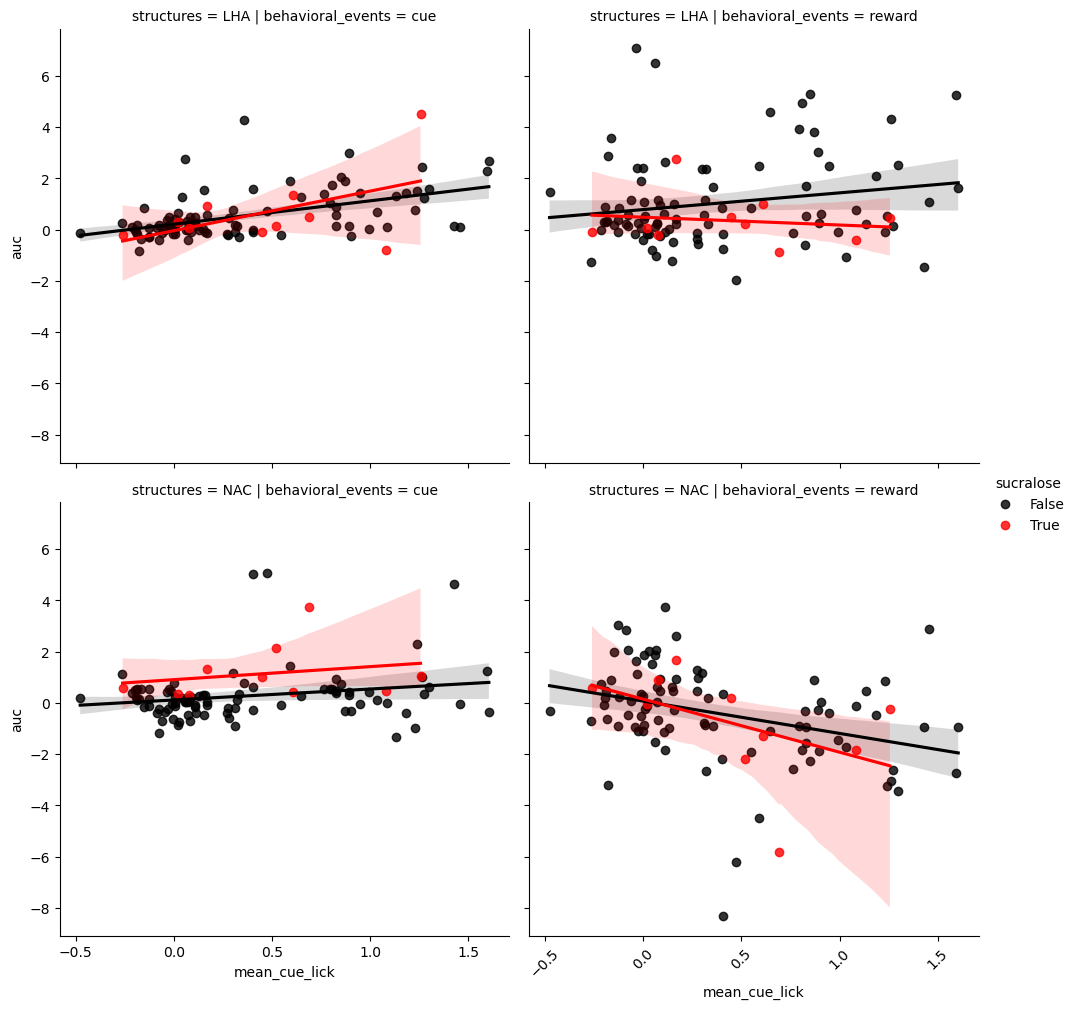

In [132]:

trained_data = final_data.filter(
    pl.col('date')>filter_date
)
sns.lmplot(data=trained_data,
           x='mean_cue_lick',
           y='auc', 
           hue = 'sucralose', 
           col = 'behavioral_events',
           col_order=['cue', 'reward'], 
           row = 'structures',  
           row_order = ['LHA', 'NAC'],
           palette=['black', 'red']
)
plt.xticks(rotation=45)
plt.ylabel('Mean LHA Dopamine')
# plt.xlabel('Mean lick frequency')
# plt.title('Cue Evoked Mean LHA Dopamine vs Mean Lick Frequency')
sns.despine()
plt.show()